# Projet : Classification de Panneaux de Signalisation Routière

Authors : 
- SANOGO Fanta
- WABO Robin
- BENLARBI Ilias
- ATJI Cheick

A.k.A Team F.R.I.C.

Objectif : Comprendre le problème de la classification de panneaux de signalisation et l’importance de cette tâche dans les systèmes de conduite autonome.

# Importation et prétraitement des données

In [1]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

import os
import shutil

import pandas as pd
import numpy as np

import random
import time
import warnings
warnings.filterwarnings(action = 'ignore')
random.seed(123)

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf



## Importation du dataset

In [2]:
# Chemin d'accès aux données
train_path = "./Train.csv"
test_path = "./Test.csv"

def importing(path:str):
    data = kagglehub.load_dataset(
                                  KaggleDatasetAdapter.PANDAS,
                                  "meowmeowmeowmeowmeow/gtsrb-german-traffic-sign",
                                  path,
                                  )
    return data

train_df = importing(train_path)
test_df = importing(test_path)


# Chemin du dataset d'origine
inputdir = "/kaggle/input/"    

print(os.listdir(inputdir))
test_df.iloc[1000:1006]

['Meta', 'meta', 'Meta.csv', 'Train.csv', 'Test.csv', 'Test', 'test', 'Train', 'train']


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
1000,43,51,5,6,38,46,17,Test/01000.png
1001,40,41,5,6,34,35,1,Test/01001.png
1002,28,30,6,6,23,25,12,Test/01002.png
1003,94,95,9,8,86,87,12,Test/01003.png
1004,33,34,5,6,28,29,10,Test/01004.png
1005,59,58,6,5,54,53,5,Test/01005.png


## Redimensionnement & Normalisation des données

In [3]:
# Fonction pour homogénéiser les dimensions des images et normaliser les pixels

def readimage(path:str, normalise:bool=False):
    
    """--Docstring--
    Args:
        path: sring path to load image
        normalise: boolean to normalise pixels (default=False)
    
    """
    # read and load images 
    img = cv2.imread(os.path.join(inputdir,path))

    # resize image in format (32 x 32) and set RGB 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    img = cv2.resize(img, (32, 32))

    # Normalize image if true
    if normalise is True:
        img = img/255
    
    return img

# Chargement des images dans la matrice des features
# inputdir = "/kaggle/input/gtsrb-german-traffic-sign/"

X_origin = np.array([image for image in (inputdir + train_df["Path"]).apply(lambda x: readimage(x))])

X_normalized = np.array([image for image in (inputdir + train_df["Path"]).apply(lambda x: readimage(x, normalise=True))])

X_test = np.array([image for image in (inputdir + test_df["Path"]).apply(lambda x: readimage(x))])

# Chargement des classes (targets)
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

y = to_categorical(train_df['ClassId']).astype('float32')
y_test = to_categorical(test_df['ClassId']).astype('float32')

X_train, X_val, y_train, y_val = train_test_split(X_normalized, y, test_size=0.2, random_state=42)


# Affichage
print(f"Training Sets:\nX_train_shape: {X_train.shape} ------ Y_train_shape: {y_train.shape}")
print(f"\nValidation Sets:\nX_val_shape: {X_val.shape}-------Y_val_shape: {y_val.shape}")
print(f"\nTest Sets:\nX_test_shape: {X_test.shape}-------Y_test_shape: {y_test.shape}")


Training Sets:
X_train_shape: (31367, 32, 32, 3) ------ Y_train_shape: (31367, 43)

Validation Sets:
X_val_shape: (7842, 32, 32, 3)-------Y_val_shape: (7842, 43)

Test Sets:
X_test_shape: (12630, 32, 32, 3)-------Y_test_shape: (12630, 43)


## Augmentation des données avec ImageDataGenerator
- Notice
- Ici, nous utiliserons le train des données non normalisées (X_origin)
  avant de procéder à l'augmentation pour des questions de bonne pratique :) 

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Génération des trains, vals pour ImageDataGenerator
X_train_aug, X_val_aug, y_train_aug, y_val_aug = train_test_split(X_origin, 
                                                                  y, 
                                                                  test_size=0.2, 
                                                                  random_state=42)

# Crée un générateur d'augmentation des données
datagen = ImageDataGenerator(
                                rescale=1./255,
                                rotation_range=3,  # Rotation aléatoire
                                width_shift_range=0.05,  # Décalage horizontal
                                height_shift_range=0.05,  # Décalage vertical
                                shear_range=0.05,  # Transformation en cisaillement
                                zoom_range=0.05,  # Zoom aléatoire
                                horizontal_flip=False,  # Miroir horizontal
                                vertical_flip=False,  # Miroir horizontal
                                fill_mode='nearest'
                            )

train_generator = datagen.flow(X_train_aug, y_train_aug)


val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow(X_val_aug, y_val_aug)

## Équilibrage des classes avec Compute_Class_weight

In [5]:
print(np.bincount(y_train.argmax(axis=1)))

[ 166 1746 1798 1115 1560 1528  338 1164 1127 1166 1661 1078 1646 1719
  613  503  355  879  962  161  282  267  304  401  211 1202  478  193
  441  211  355  620  199  551  332  976  310  163 1652  242  300  193
  199]


In [6]:
from sklearn.utils.class_weight import compute_class_weight

y_train_classes = np.argmax(y_train, axis=1)  # Si y_train est one-hot

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_classes), y=y_train_classes)

class_weights_dict = dict(zip(np.unique(y_train_classes), class_weights))
print(class_weights_dict)

{0: 4.394368170355842, 1: 0.4177921628173366, 2: 0.4057091859171689, 3: 0.6542288038377307, 4: 0.46760584376863445, 5: 0.4773986363082917, 6: 2.1581808173936974, 7: 0.626688244226005, 8: 0.6472627473638596, 9: 0.6256133072719294, 10: 0.439172255435924, 11: 0.6766837813349441, 12: 0.44317443273333523, 13: 0.4243543433851482, 14: 1.1899920330816798, 15: 1.4502288594017292, 16: 2.0548313134621683, 17: 0.8298806783607164, 18: 0.7582797466518397, 19: 4.530839231547017, 20: 2.586755731486063, 21: 2.732079087187527, 22: 2.3995563035495717, 23: 1.8191150031897, 24: 3.4571806458723686, 25: 0.606876136671439, 26: 1.5260776491193928, 27: 3.7796120014459573, 28: 1.6541159099298635, 29: 3.4571806458723686, 30: 2.0548313134621683, 31: 1.17655663915979, 32: 3.665653850648592, 33: 1.3238931329928671, 34: 2.197184085177921, 35: 0.7474027830728174, 36: 2.35311327831958, 37: 4.475246112141532, 38: 0.44156484036263305, 39: 3.0143186623102056, 40: 2.431550387596899, 41: 3.7796120014459573, 42: 3.6656538506

# Modèles

## Modèle Simple CNN

In [7]:
from tensorflow.keras import layers
from tensorflow.keras import models

modelsimple = models.Sequential()
modelsimple.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)))
modelsimple.add(layers.MaxPooling2D((2, 2)))

modelsimple.add(layers.Conv2D(64, (3, 3), activation='relu'))
modelsimple.add(layers.MaxPooling2D((2, 2)))

modelsimple.add(layers.Conv2D(64, (3, 3), activation='relu'))
modelsimple.add(layers.MaxPooling2D((2, 2)))

modelsimple.add(layers.Flatten())
modelsimple.add(layers.Dense(512, activation='relu'))

modelsimple.add(layers.Dense(256, activation='relu'))

modelsimple.add(layers.Dense(128, activation='relu'))
modelsimple.add(layers.Dropout(0.5))


modelsimple.add(layers.Dense(43, activation='softmax'))

modelsimple.summary()

modelsimple.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 43)                  │           5,547 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 377,003 (1.44 MB)

 Trainable params: 377,003 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

## Modèle Simple CNN avec early stopping et kernel_regularizer

In [8]:
# Ajout d'early stopping et kernel_regularizer (l2 et l1 ) pour prévenir le surapprentissage

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

modelsimple2 = models.Sequential()
modelsimple2.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)))
modelsimple2.add(layers.MaxPooling2D((2, 2)))

modelsimple2.add(layers.Conv2D(64, (3, 3), activation='relu'))
modelsimple2.add(layers.MaxPooling2D((2, 2)))

modelsimple2.add(layers.Conv2D(64, (3, 3), activation='relu'))
modelsimple2.add(layers.MaxPooling2D((2, 2)))

modelsimple2.add(layers.Flatten())
modelsimple2.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

modelsimple2.add(layers.Dense(256, activation='relu'))
                              
modelsimple2.add(layers.Dense(128, activation='relu',  kernel_regularizer=regularizers.l1_l2(0.001, 0.001)))
modelsimple2.add(layers.Dropout(0.5))


modelsimple2.add(layers.Dense(43, activation='softmax'))

modelsimple2.summary()



modelsimple2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 30, 30, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 13, 13, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 43)                  │           5,547 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 377,003 (1.44 MB)

 Trainable params: 377,003 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

## Modèle VGG16 "créé"

In [9]:
from tensorflow.keras import layers, models, regularizers

model_vgg16 = models.Sequential()

# Blocs de convolution
model_vgg16.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model_vgg16.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model_vgg16.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_vgg16.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model_vgg16.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model_vgg16.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_vgg16.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model_vgg16.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model_vgg16.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Couches Fully Connected allégées
model_vgg16.add(layers.Flatten())
model_vgg16.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_vgg16.add(layers.Dropout(0.3))
model_vgg16.add(layers.BatchNormalization())

model_vgg16.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_vgg16.add(layers.Dropout(0.3))
model_vgg16.add(layers.BatchNormalization())

model_vgg16.add(layers.Dense(43, activation='softmax'))

model_vgg16.summary()

model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])




Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 43)                  │          11,051 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,388,523 (12.93 MB)

 Trainable params: 3,386,987 (12.92 MB)

 Non-trainable params: 1,536 (6.00 KB)

## Modèle VGG16 Importé

In [10]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import VGG16

# Charger le modèle VGG16 pré-entraîné sans la couche de sortie (top=False)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Création du modèle personnalisé VGG16
model_vgg16lib = models.Sequential()

# Ajouter la base VGG16
model_vgg16lib.add(base_model)

# Ajouter des couches supplémentaires pour la classification avec régularisation L2 et Dropout

# Aplatir les sorties de la base VGG16
model_vgg16lib.add(layers.Flatten())

# Couches Fully Connected avec L2 regularization et Dropout
model_vgg16lib.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_vgg16lib.add(layers.Dropout(0.5))  # Dropout avec un taux de 50%
model_vgg16lib.add(layers.BatchNormalization())  # Normalisation par lot pour accélérer l'entraînement

model_vgg16lib.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_vgg16lib.add(layers.Dropout(0.5))  # Dropout avec un taux de 50%
model_vgg16lib.add(layers.BatchNormalization())

# Couche de sortie pour la classification (par exemple 43 classes)
model_vgg16lib.add(layers.Dense(43, activation='softmax'))

# Résumé du modèle
model_vgg16lib.summary()

# Compilation du modèle avec l'optimiseur Adam et la fonction de perte pour classification multiclasse
model_vgg16lib.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 1, 1, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 43)                  │          11,051 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,122,795 (57.69 MB)

 Trainable params: 15,121,259 (57.68 MB)

 Non-trainable params: 1,536 (6.00 KB)

# Application des modèles

## Modèle Simple CNN (avec les données originelles)

Epoch 1/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.0895 - loss: 3.3191 - val_accuracy: 0.5297 - val_loss: 1.3557
Epoch 2/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5545 - loss: 1.2432 - val_accuracy: 0.8346 - val_loss: 0.5091
Epoch 3/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8154 - loss: 0.4256 - val_accuracy: 0.9111 - val_loss: 0.2616
Epoch 4/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9018 - loss: 0.2363 - val_accuracy: 0.9480 - val_loss: 0.1633
Epoch 5/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9384 - loss: 0.1489 - val_accuracy: 0.9575 - val_loss: 0.1346
Epoch 6/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9508 - loss: 0.1212 - val_accuracy: 0.9638 - val_loss: 0.1194
Epoch 7/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9645 - loss: 0.0820 - val_accuracy: 0.9662 - val_loss: 0.1125
Epoch 8/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9601 - loss: 0.1065 - val_accuracy: 

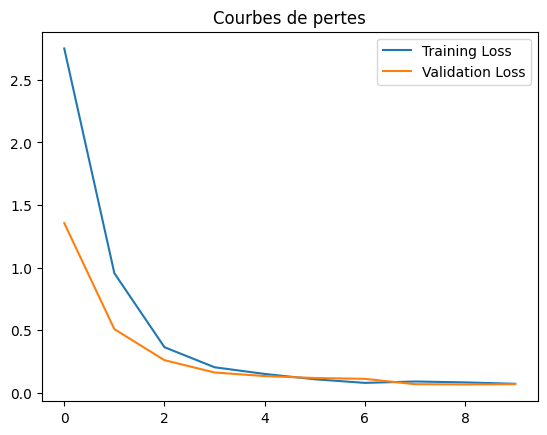

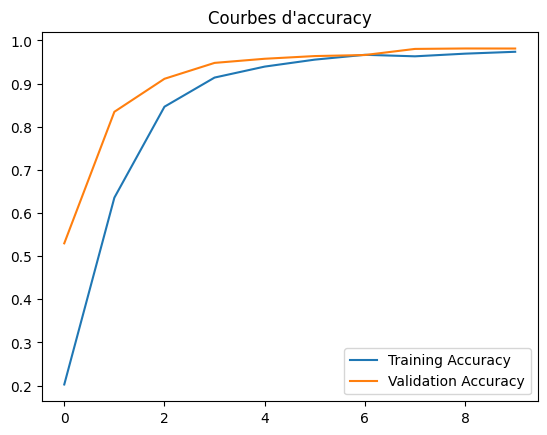

In [11]:
history = modelsimple.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val), class_weight=class_weights_dict)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Courbes de pertes')
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Courbes d'accuracy")
plt.show()

## Modèle Simple CNN (avec augmentation d'images)

Epoch 1/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - accuracy: 0.8749 - loss: 0.4091 - val_accuracy: 0.9660 - val_loss: 0.1010
Epoch 2/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9273 - loss: 0.2014 - val_accuracy: 0.9796 - val_loss: 0.0750
Epoch 3/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9520 - loss: 0.1450 - val_accuracy: 0.9802 - val_loss: 0.0709
Epoch 4/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9587 - loss: 0.1212 - val_accuracy: 0.9765 - val_loss: 0.0765
Epoch 5/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9624 - loss: 0.1133 - val_accuracy: 0.9804 - val_loss: 0.0655
Epoch 6/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9576 - loss: 0.1378 - val_accuracy: 0.9809 - val_loss: 0.0610
Epoch 7/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9723 - loss: 0.0798 - val_accuracy: 0.9867 - val_loss: 0.0527
Epoch 8/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9719 - loss: 0.0823 - 

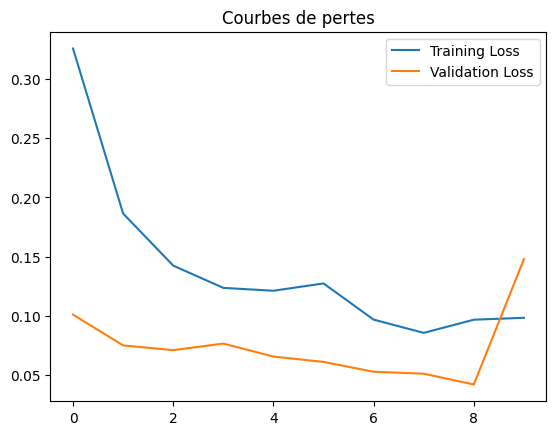

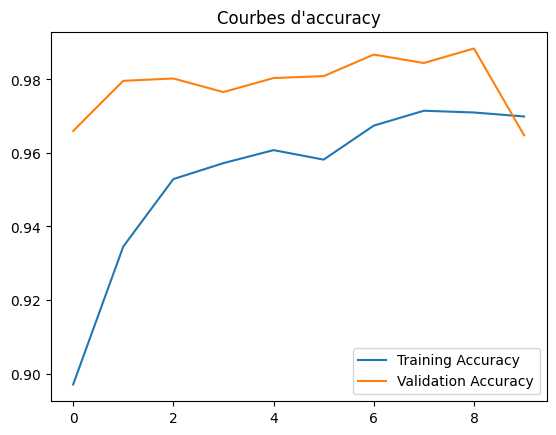

In [12]:
history = modelsimple.fit(train_generator, epochs=10, batch_size=64 , validation_data=val_generator, class_weight=class_weights_dict)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Courbes de pertes')
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Courbes d'accuracy")
plt.show()

## Modèle Simple CNN avec early stopping et kernel_regularization (avec les données originelles)

Epoch 1/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.0354 - loss: 4.5214 - val_accuracy: 0.0801 - val_loss: 2.8631
Epoch 2/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1263 - loss: 2.7565 - val_accuracy: 0.2666 - val_loss: 2.1240
Epoch 3/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2574 - loss: 2.3104 - val_accuracy: 0.3829 - val_loss: 1.7511
Epoch 4/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3747 - loss: 1.9220 - val_accuracy: 0.5768 - val_loss: 1.3144
Epoch 5/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4896 - loss: 1.5076 - val_accuracy: 0.6382 - val_loss: 1.1330
Epoch 6/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5927 - loss: 1.2173 - val_accuracy: 0.7494 - val_loss: 0.9146
Epoch 7/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6408 - loss: 1.0608 - val_accuracy: 0.7559 - val_loss: 0.8600
Epoch 8/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6852 - loss: 0.9369 - val_accuracy: 0

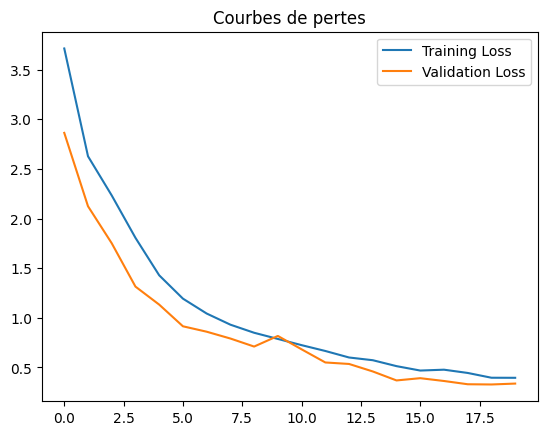

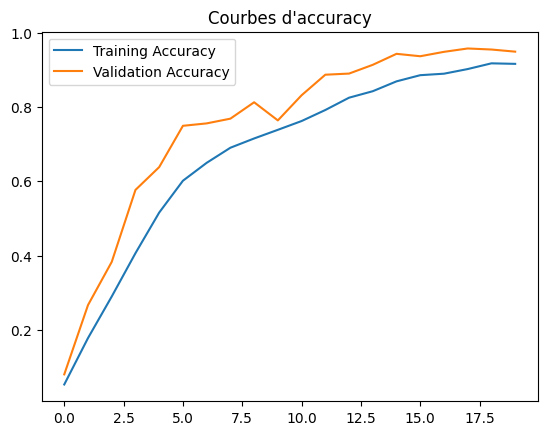

In [13]:
history = modelsimple2.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping], class_weight=class_weights_dict)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Courbes de pertes')
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Courbes d'accuracy")
plt.show()

## Modèle Simple CNN avec early stopping et kernel_regularization (avec augmentation d'images)

Epoch 1/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0965 - loss: 16.8431 - val_accuracy: 0.0099 - val_loss: 4.2402
Epoch 2/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0091 - loss: 4.1827 - val_accuracy: 0.0099 - val_loss: 4.1383
Epoch 3/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0090 - loss: 4.1705 - val_accuracy: 0.0099 - val_loss: 4.0676
Epoch 4/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0081 - loss: 4.0228 - val_accuracy: 0.0062 - val_loss: 4.0044
Epoch 5/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0069 - loss: 4.0055 - val_accuracy: 0.0062 - val_loss: 3.9401


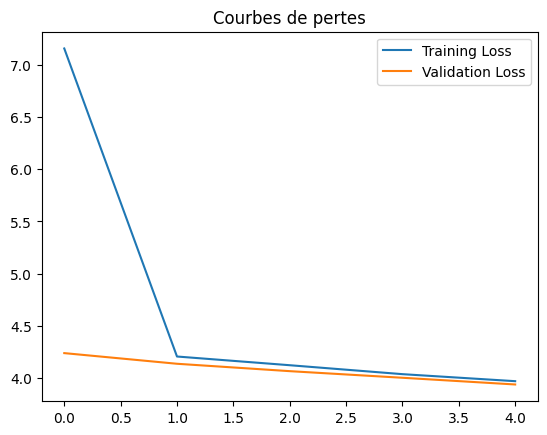

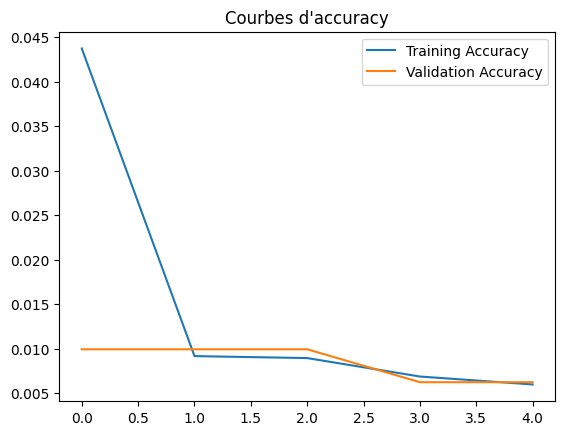

In [14]:
history = modelsimple2.fit(X_train_aug, y_train_aug, epochs=20, batch_size=32, validation_data=(X_val_aug, y_val_aug), callbacks=[early_stopping], class_weight=class_weights_dict)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Courbes de pertes')
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Courbes d'accuracy")
plt.show()

## Modèle VGG16 "créé" avec les données originelles

Epoch 1/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.0706 - loss: 7.6725 - val_accuracy: 0.0154 - val_loss: 4.6959
Epoch 2/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.5961 - loss: 1.9796 - val_accuracy: 0.8838 - val_loss: 1.0571
Epoch 3/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9036 - loss: 0.7030 - val_accuracy: 0.9424 - val_loss: 0.5427
Epoch 4/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9475 - loss: 0.4644 - val_accuracy: 0.9702 - val_loss: 0.3836
Epoch 5/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9542 - loss: 0.4287 - val_accuracy: 0.9630 - val_loss: 0.4405
Epoch 6/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9622 - loss: 0.4240 - val_accuracy: 0.9791 - val_loss: 0.3019
Epoch 7/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9642 - loss: 0.4002 - val_accuracy: 0.9788 - val_loss: 0.2814
Epoch 8/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9598 - loss: 0.4059 - val_acc

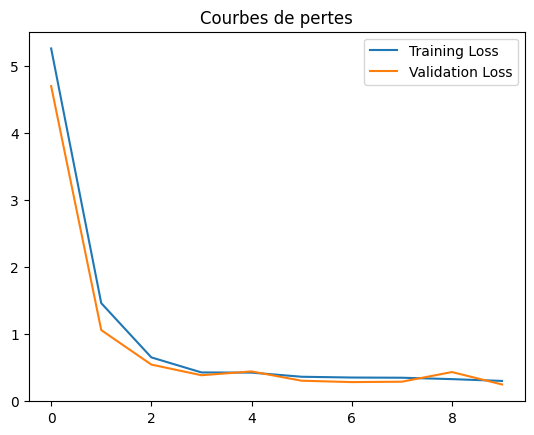

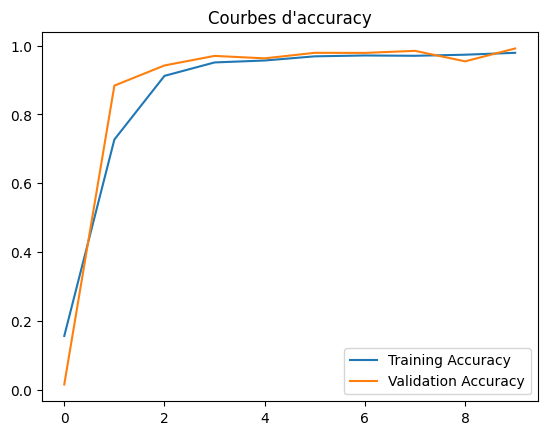

In [15]:
history = model_vgg16.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val), class_weight=class_weights_dict)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Courbes de pertes')
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Courbes d'accuracy")
plt.show()

## Modèle VGG16 (avec augmentation d'images)

Epoch 1/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 45s 70ms/step - accuracy: 0.0377 - loss: 7.4923 - val_accuracy: 0.0970 - val_loss: 3.9840
Epoch 2/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - accuracy: 0.0727 - loss: 3.7267 - val_accuracy: 0.1025 - val_loss: 3.1703
Epoch 3/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 24s 50ms/step - accuracy: 0.0958 - loss: 3.1256 - val_accuracy: 0.1571 - val_loss: 2.6620
Epoch 4/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 24s 50ms/step - accuracy: 0.1199 - loss: 2.8640 - val_accuracy: 0.1268 - val_loss: 2.7189
Epoch 5/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 24s 50ms/step - accuracy: 0.1283 - loss: 2.7644 - val_accuracy: 0.1333 - val_loss: 2.5310
Epoch 6/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 24s 50ms/step - accuracy: 0.1326 - loss: 2.6693 - val_accuracy: 0.1386 - val_loss: 2.4655
Epoch 7/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - accuracy: 0.1480 - loss: 2.6099 - val_accuracy: 0.0893 - val_loss: 2.6101
Epoch 8/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 24s 50ms/step - accuracy: 0.1405 - loss: 2.6045 - 

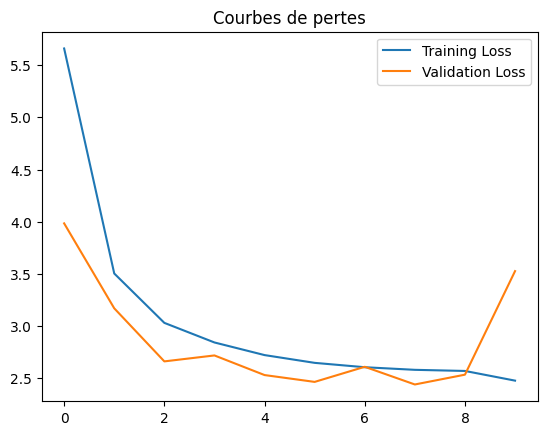

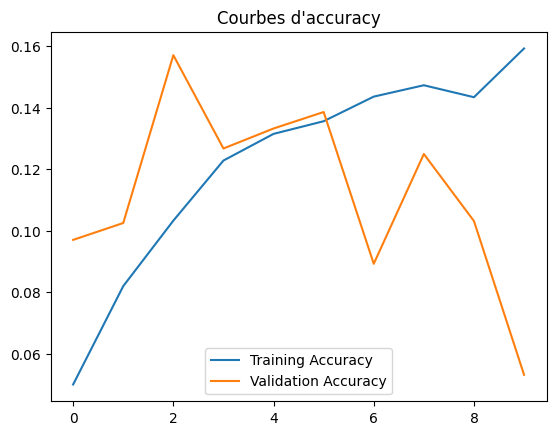

In [16]:
history = model_vgg16lib.fit(X_train_aug, y_train_aug, epochs=10, batch_size=64, validation_data=(X_val_aug, y_val_aug), class_weight=class_weights_dict)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Courbes de pertes')
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Courbes d'accuracy")
plt.show()

# Evaluation des modèles


## Modèle Simple CNN


### Accuracy et benchmarking du modèle

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[16  1 38 ...  2  7 10]
Test Accuracy: 80.62%


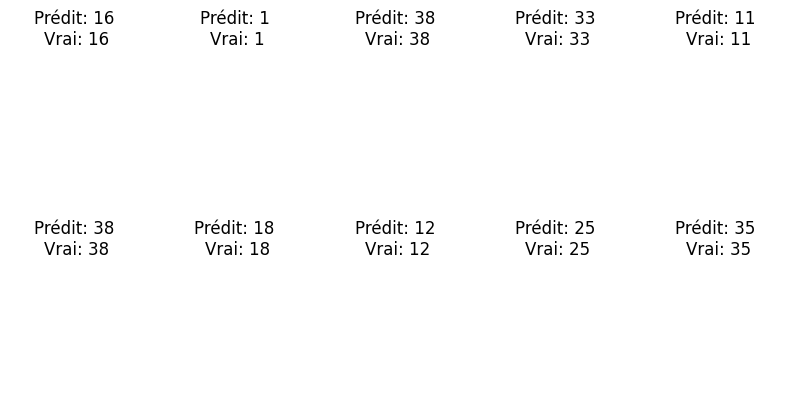

In [17]:
# Obtenir les prédictions sous forme de probabilités
pred_probs = modelsimple.predict(X_test)

# Convertir en classes en prenant l'indice du max de probabilité
predCNN = np.argmax(pred_probs, axis=1)

print(predCNN)

from sklearn.metrics import accuracy_score

# Si y_test est one-hot, convertir en indices de classe
y_test_classes = np.argmax(y_test, axis=1)

# Calcul de la précision
accuracy = accuracy_score(y_test_classes, predCNN)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

import matplotlib.pyplot as plt

# Afficher quelques images avec leurs prédictions
plt.figure(figsize=(10, 5))
for i in range(10):  # Afficher 10 images
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[i])  # Afficher l'image
    plt.title(f"Prédit: {predCNN[i]} \nVrai: {y_test_classes[i]}")
    plt.axis("off")
plt.show()


## Modèle Simple CNN avec early stopping et kernel_regularization


### Accuracy et benchmarking du modèle

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
[16  1 38 ...  2  7 10]
Test Accuracy: 80.62%


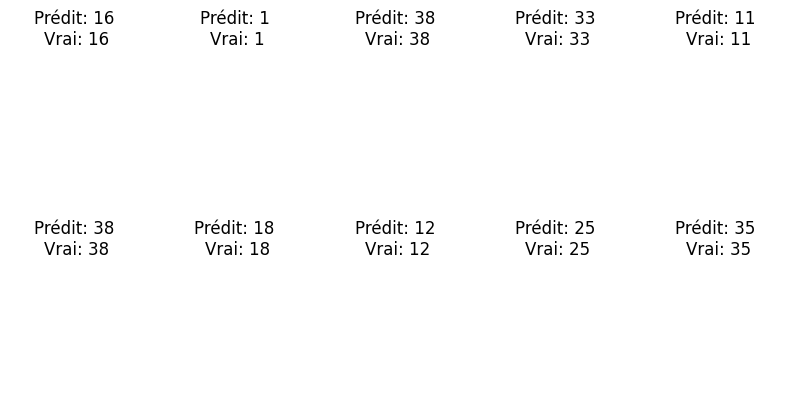

In [18]:
# Obtenir les prédictions sous forme de probabilités
pred_probs = modelsimple.predict(X_test)

# Convertir en classes en prenant l'indice du max de probabilité
predCNN2 = np.argmax(pred_probs, axis=1)

print(predCNN2)

from sklearn.metrics import accuracy_score

# Si y_test est one-hot, convertir en indices de classe
y_test_classes = np.argmax(y_test, axis=1)

# Calcul de la précision
accuracy = accuracy_score(y_test_classes, predCNN2)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

import matplotlib.pyplot as plt

# Afficher quelques images avec leurs prédictions
plt.figure(figsize=(10, 5))
for i in range(10):  # Afficher 10 images
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[i])  # Afficher l'image
    plt.title(f"Prédit: {predCNN2[i]} \nVrai: {y_test_classes[i]}")
    plt.axis("off")
plt.show()


## Modèle VGG16


### Accuracy et benchmarking du modèle

395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
[16  1 38 ... 12  7 10]
Test Accuracy: 89.06%


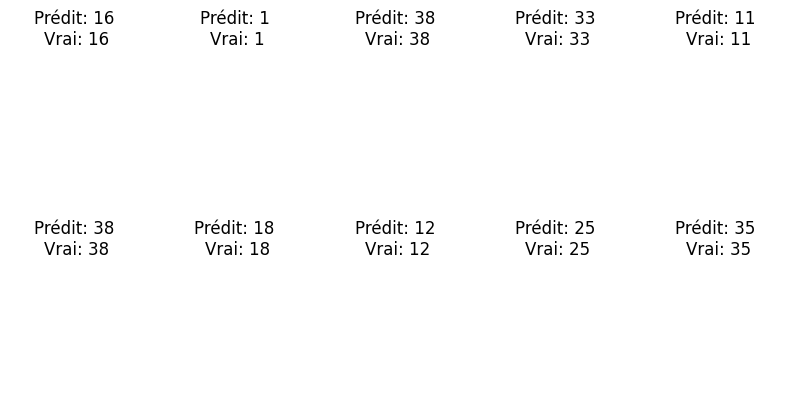

In [19]:
# Obtenir les prédictions sous forme de probabilités
pred_probs = model_vgg16.predict(X_test)

# Convertir en classes en prenant l'indice du max de probabilité
predVGG = np.argmax(pred_probs, axis=1)

print(predVGG)

from sklearn.metrics import accuracy_score

# Si y_test est one-hot, convertir en indices de classe
y_test_classes = np.argmax(y_test, axis=1)

# Calcul de la précision
accuracy = accuracy_score(y_test_classes, predVGG)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

import matplotlib.pyplot as plt

# Afficher quelques images avec leurs prédictions
plt.figure(figsize=(10, 5))
for i in range(10):  # Afficher 10 images
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[i])  # Afficher l'image
    plt.title(f"Prédit: {predVGG[i]} \nVrai: {y_test_classes[i]}")
    plt.axis("off")
plt.show()


## Courbe de ROC et matrices de confusion

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


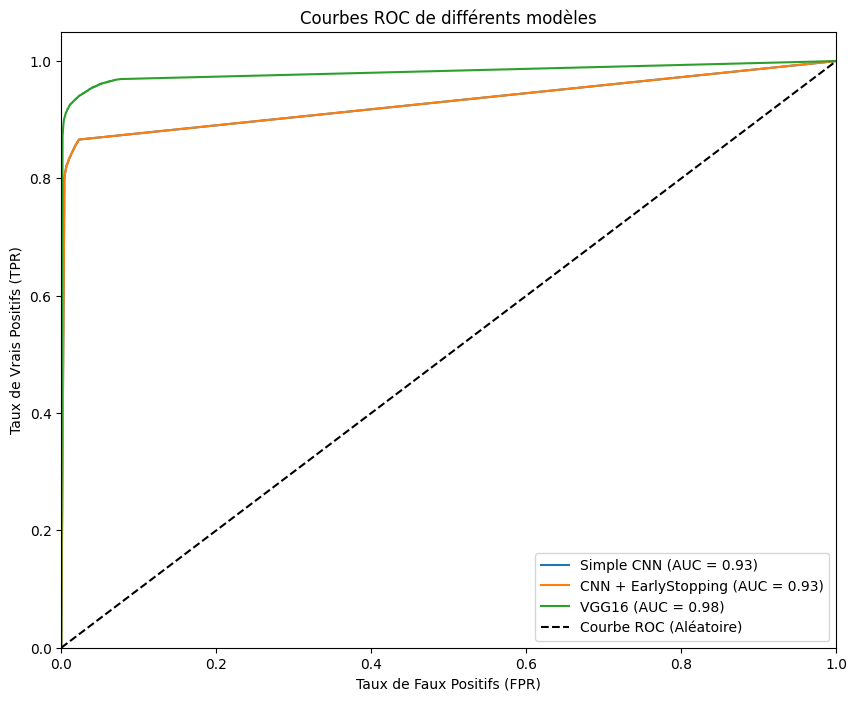


Métriques pour Simple CNN :
- Précision : 0.85
- Rappel : 0.81
- F1-score : 0.81


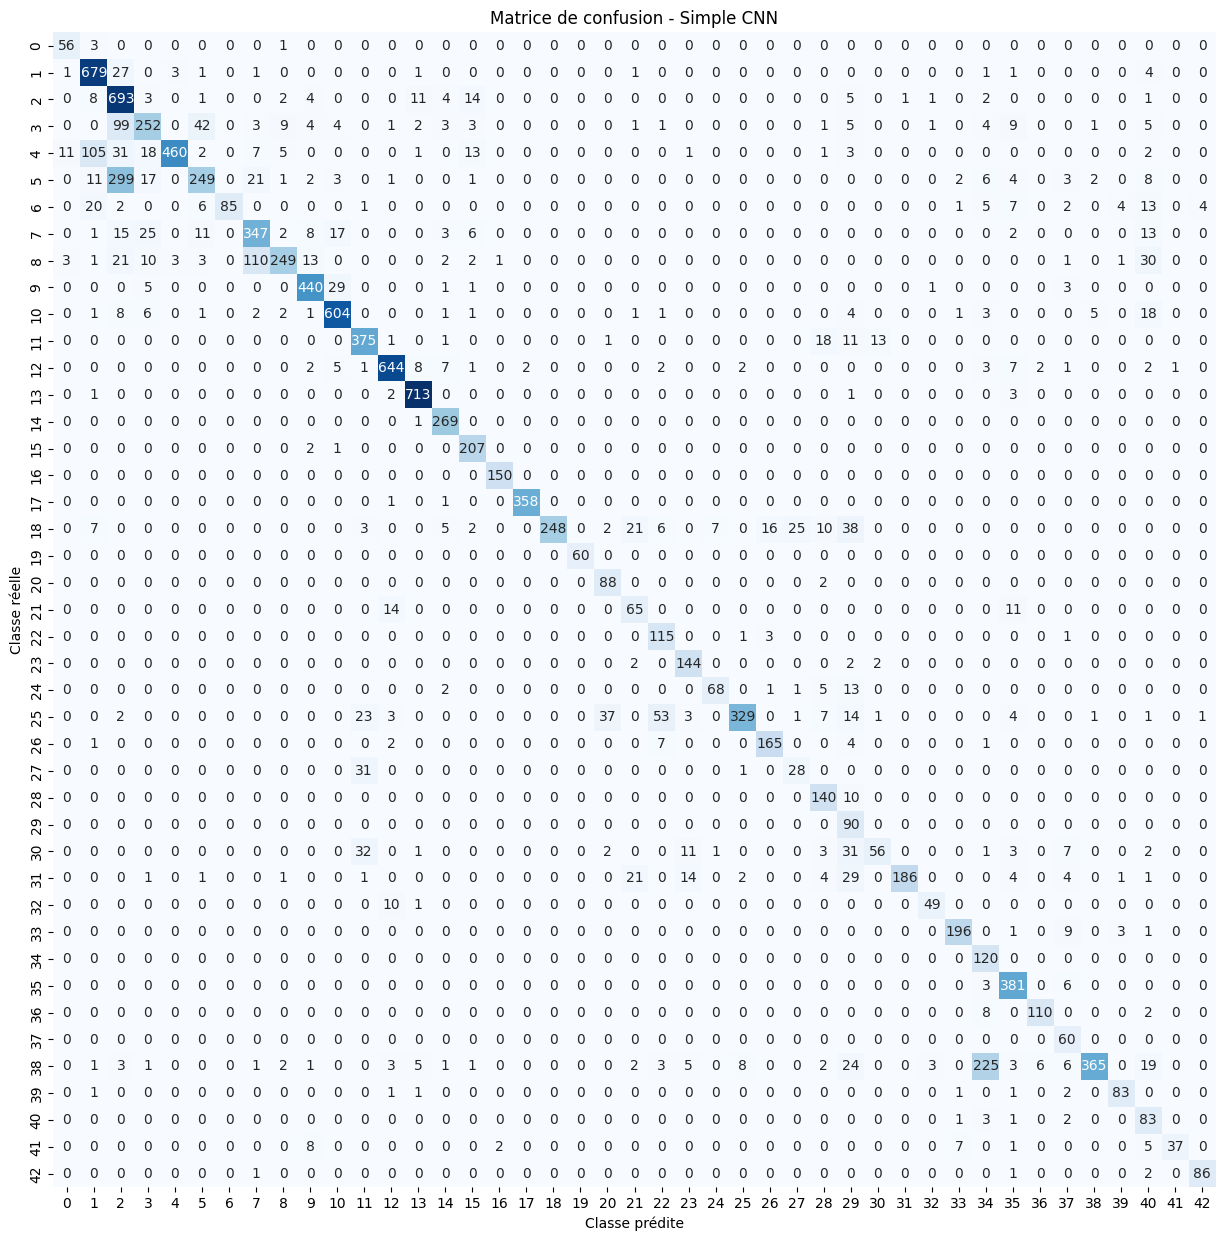


Métriques pour CNN + EarlyStopping :
- Précision : 0.85
- Rappel : 0.81
- F1-score : 0.81


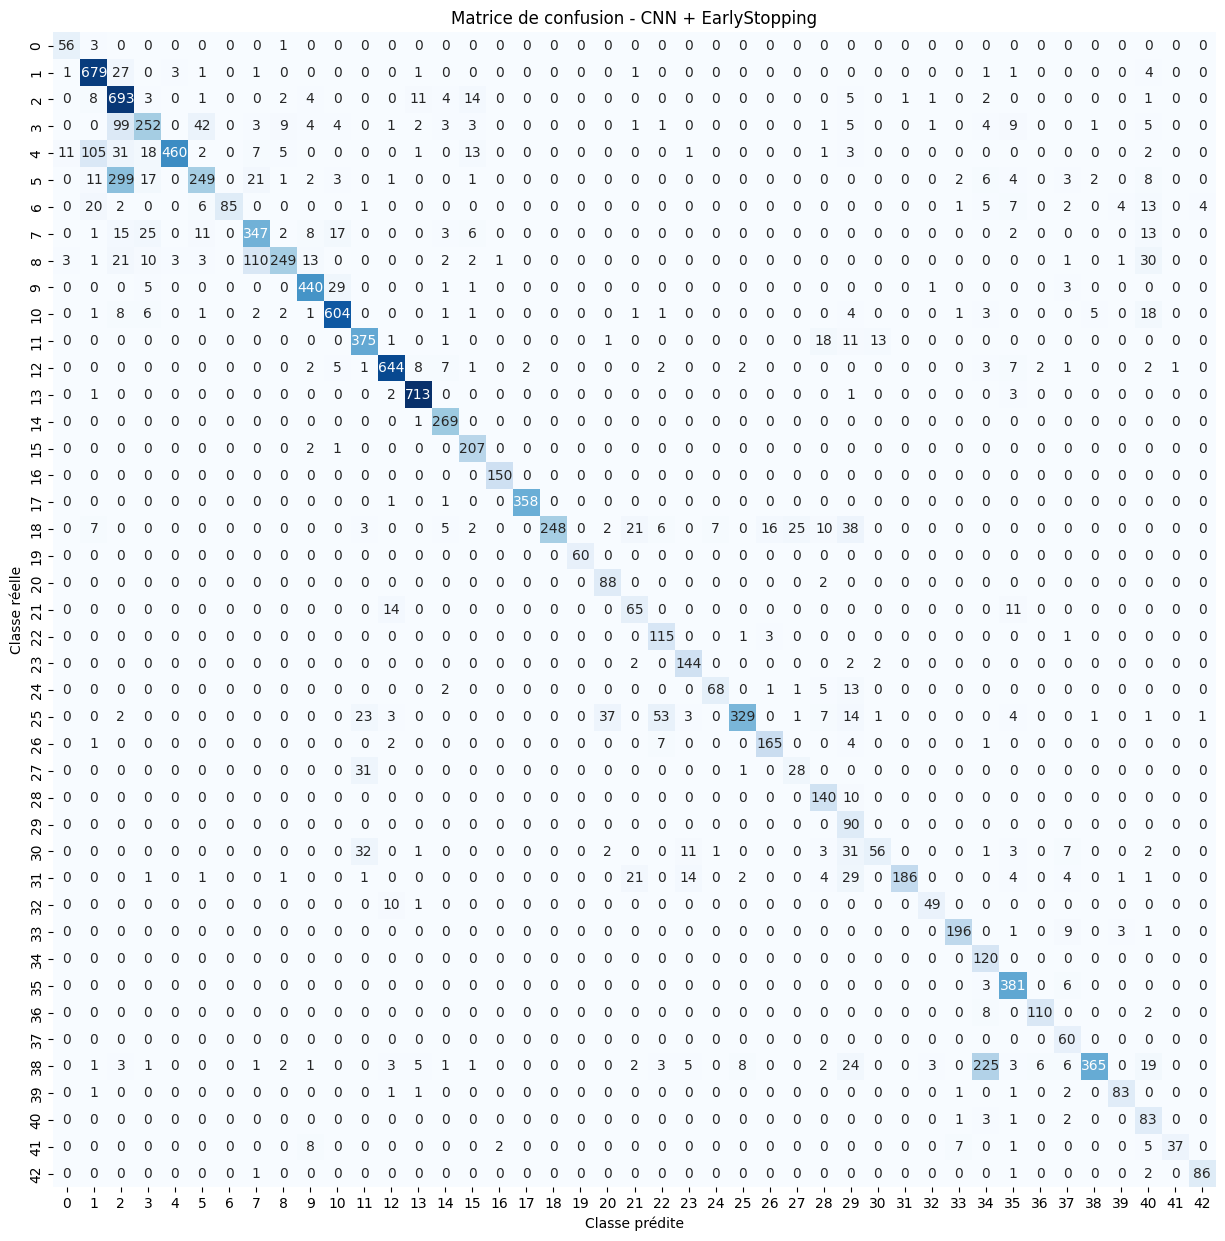


Métriques pour VGG16 :
- Précision : 0.92
- Rappel : 0.89
- F1-score : 0.90


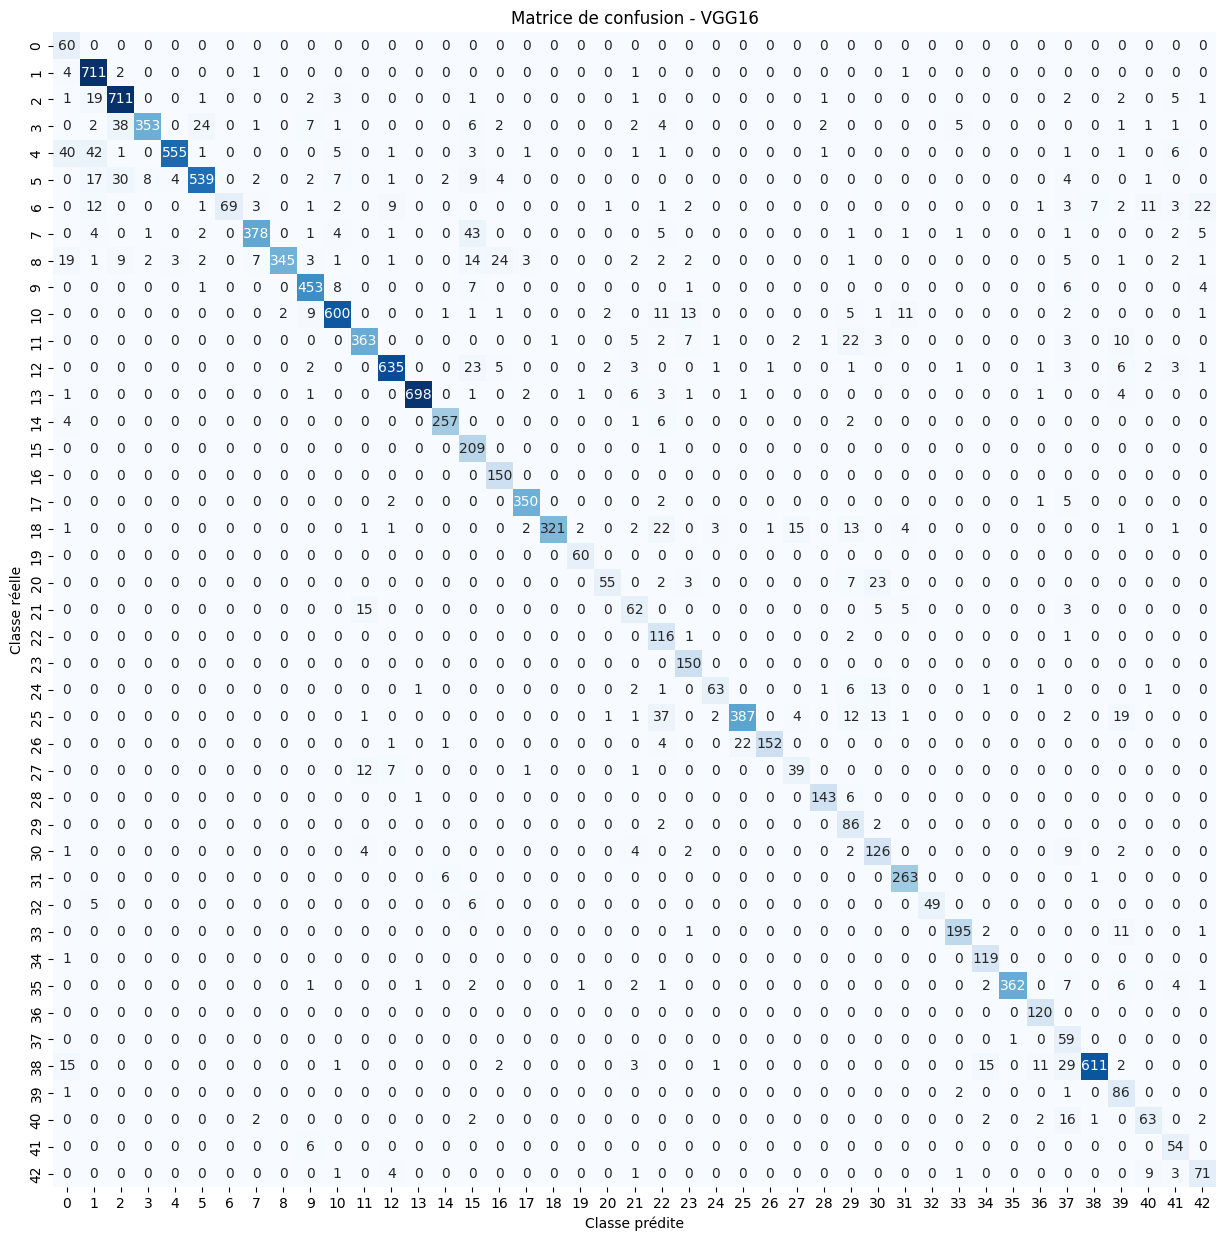

In [20]:
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import label_binarize


# Binariser les étiquettes
n_classes = len(np.unique(y_test_classes))
y_test_bin = label_binarize(y_test_classes, classes=np.arange(n_classes))

# Probabilités de chaque modèle
probs_simple = modelsimple.predict(X_test)
probs_cnn2 = modelsimple.predict(X_test)  
probs_vgg = model_vgg16.predict(X_test)



# Fonction pour tracer la courbe ROC et calculer l'AUC
def plot_roc_curve(y_true, y_probs, model_name):
    fpr, tpr, _ = roc_curve(y_true.ravel(), y_probs.ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

# affichage des métriques de performance
def evaluate_model(y_true, y_probs, model_name):
    y_pred = np.argmax(y_probs, axis=1)  

    # Calcul des métriques
    precision = precision_score(y_test_classes, y_pred, average='weighted')
    recall = recall_score(y_test_classes, y_pred, average='weighted')
    f1 = f1_score(y_test_classes, y_pred, average='weighted')

    print(f"\nMétriques pour {model_name} :")
    print(f"- Précision : {precision:.2f}")
    print(f"- Rappel : {recall:.2f}")
    print(f"- F1-score : {f1:.2f}")

    # Matrice de confusion avec seaborn heatmap
    cm = confusion_matrix(y_test_classes, y_pred)
    plt.figure(figsize=(15, 15))  
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)  
    plt.title(f'Matrice de confusion - {model_name}')
    plt.xlabel('Classe prédite')
    plt.ylabel('Classe réelle')
    plt.show()

# Affichage des courbes ROC
plt.figure(figsize=(10, 8))
plot_roc_curve(y_test_bin, probs_simple, 'Simple CNN')
plot_roc_curve(y_test_bin, probs_cnn2, 'CNN + EarlyStopping')
plot_roc_curve(y_test_bin, probs_vgg, 'VGG16')

plt.plot([0, 1], [0, 1], 'k--', label='Courbe ROC (Aléatoire)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbes ROC de différents modèles')
plt.legend(loc="lower right")
plt.show()

# Calcul et affichage des métriques + matrice de confusion
evaluate_model(y_test_bin, probs_simple, 'Simple CNN')
evaluate_model(y_test_bin, probs_cnn2, 'CNN + EarlyStopping')
evaluate_model(y_test_bin, probs_vgg, 'VGG16')


# Améliorations et expérimentations

## Intégration du transfer learning avec ImageNet

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

#  VGG16 pré-entraîné
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(43, activation='softmax')(x)  

model_vgg16_transfer = Model(inputs=base_model.input, outputs=predictions)
# Transfer Learning, cela permet d'éviter la modification des poids pré-entraînés lors de la 1ére phase d'entraînement
for layer in base_model.layers:
    layer.trainable = False
# entrainement du modèle
model_vgg16_transfer.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history_vgg16_transfer = model_vgg16_transfer.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.2956 - loss: 2.5082 - val_accuracy: 0.5453 - val_loss: 1.5007
Epoch 2/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.5085 - loss: 1.5682 - val_accuracy: 0.6088 - val_loss: 1.2327
Epoch 3/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.5800 - loss: 1.3199 - val_accuracy: 0.6676 - val_loss: 1.0654
Epoch 4/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.6248 - loss: 1.1668 - val_accuracy: 0.6913 - val_loss: 0.9708
Epoch 5/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.6477 - loss: 1.0766 - val_accuracy: 0.7246 - val_loss: 0.8953
Epoch 6/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.6776 - loss: 0.9843 - val_accuracy: 0.7410 - val_loss: 0.8083
Epoch 7/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.6970 - loss: 0.9156 - val_accuracy: 0.7661 - val_loss: 0.7520
Epoch 8/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.7164 - loss: 0.8644 - val_accuracy: 

## Évaluation du modèle fine-tuning

In [22]:
for layer in model_vgg16_transfer.layers[-4:]: # par exemple les 4 dernieres couches.
    layer.trainable = True

model_vgg16_transfer.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history_vgg16_transfer_ft = model_vgg16_transfer.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.8413 - loss: 0.4721 - val_accuracy: 0.8720 - val_loss: 0.4193
Epoch 2/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8558 - loss: 0.4313 - val_accuracy: 0.8739 - val_loss: 0.4134
Epoch 3/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8579 - loss: 0.4325 - val_accuracy: 0.8758 - val_loss: 0.4114
Epoch 4/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8608 - loss: 0.4200 - val_accuracy: 0.8767 - val_loss: 0.4068
Epoch 5/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8628 - loss: 0.4201 - val_accuracy: 0.8757 - val_loss: 0.4053
Epoch 6/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8634 - loss: 0.4135 - val_accuracy: 0.8763 - val_loss: 0.4022
Epoch 7/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8629 - loss: 0.4156 - val_accuracy: 0.8796 - val_loss: 0.3989
Epoch 8/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8661 - loss: 0.4104 - val_accuracy: 

# Interprétation et Visualisation des résultats

## Grad-CAM

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


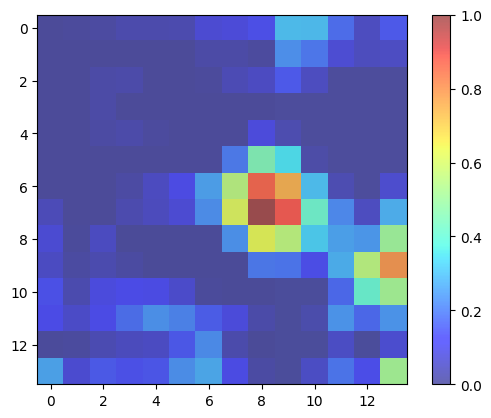

In [30]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model



base_model = VGG16(weights='imagenet')


img_path = "/kaggle/input/Test/02000.png"  
img = load_img(img_path, target_size=(224, 224)) 
img_array = img_to_array(img)  
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array) 


predictions = base_model.predict(img_array)
predicted_class = np.argmax(predictions)


last_conv_layer = base_model.get_layer('block5_conv3')


grad_model = Model(inputs=base_model.inputs,
                   outputs=[last_conv_layer.output, base_model.output])


with tf.GradientTape() as tape:
    last_conv_layer_output, model_output = grad_model(img_array)
    tape.watch(last_conv_layer_output)
    loss = model_output[:, predicted_class]  


grads = tape.gradient(loss, last_conv_layer_output)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  
pooled_grads = pooled_grads.numpy()


last_conv_layer_output = last_conv_layer_output[0].numpy()
for i in range(last_conv_layer_output.shape[-1]):
    last_conv_layer_output[..., i] *= pooled_grads[i]

# Générer la heatmap
heatmap = np.mean(last_conv_layer_output, axis=-1)
heatmap = np.maximum(heatmap, 0) 
heatmap /= np.max(heatmap) 

# Affichage des résultats
plt.imshow(img)
plt.imshow(heatmap, alpha=0.6, cmap='jet')  # heatmap
plt.colorbar()
plt.show()


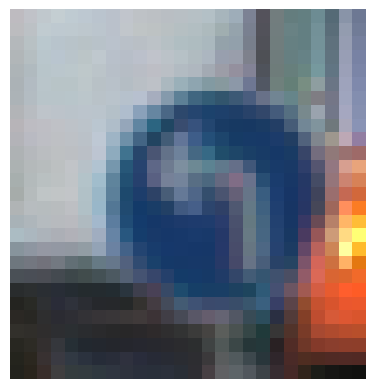

In [55]:
from PIL import Image
import matplotlib.pyplot as plt

# Charger et afficher une image
image_path = "/kaggle/input/Test/02000.png" 
imageopen = Image.open(image_path)

plt.imshow(imageopen)
plt.axis("off")
plt.show()

